<a href="https://colab.research.google.com/github/MishkaDewlok/PDAN8412_ICE3/blob/main/LSTM%2BSentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1 - imports & seeds
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb, reuters
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import re

# reproducibility (not perfect across devices, but helps)
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [ ]:
# Cell 2 - load IMDB and inspect
num_words = 10000   # we'll keep the top 10k words
maxlen = 200        # max length for each review (you can tune this)

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_words)

print("Train samples:", len(x_train), "Test samples:", len(x_test))
print("Example (first train sequence) length:", len(x_train[0]))

# show distribution of lengths (quick)
lens = [len(x) for x in x_train]
print("Median length:", np.median(lens), "Max length:", np.max(lens))


Train samples: 25000 Test samples: 25000
Example (first train sequence) length: 218
Median length: 178.0 Max length: 2494


In [ ]:
# Cell 3 - pad sequences
x_train_pad = pad_sequences(x_train, maxlen=maxlen, padding='pre', truncating='pre')
x_test_pad  = pad_sequences(x_test,  maxlen=maxlen, padding='pre', truncating='pre')

print("Padded shape:", x_train_pad.shape)
print("First padded sample (first 20 tokens):", x_train_pad[0][:20])


Padded shape: (25000, 200)
First padded sample (first 20 tokens): [  5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2]


In [ ]:
# Cell 4 - model definition (IMDB)
embedding_dim = 128

model_imdb = keras.Sequential([
    layers.Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=maxlen),
    layers.LSTM(128, return_sequences=False),   # single LSTM layer
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')      # binary output
])

model_imdb.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_imdb.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Cell 5 - training
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
]

history_imdb = model_imdb.fit(
    x_train_pad, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.6683 - loss: 0.5673 - val_accuracy: 0.8570 - val_loss: 0.3303
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8795 - loss: 0.3023 - val_accuracy: 0.8692 - val_loss: 0.3239
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9121 - loss: 0.2301 - val_accuracy: 0.8518 - val_loss: 0.3958
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9152 - loss: 0.2225 - val_accuracy: 0.8578 - val_loss: 0.4526


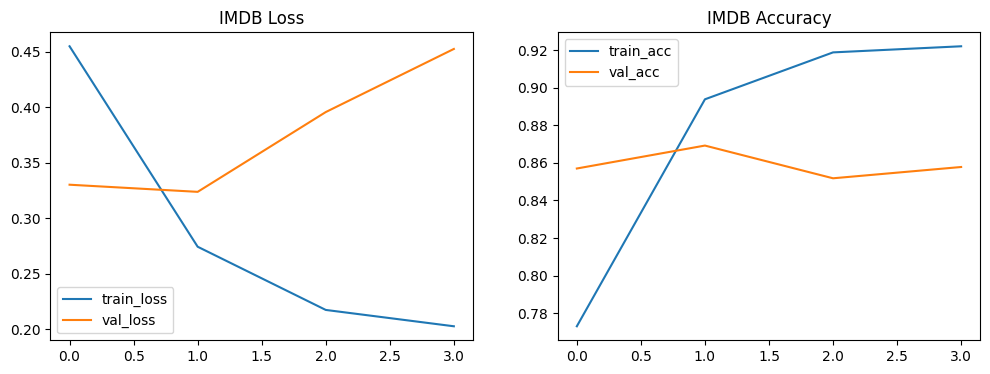

In [ ]:
# Cell 6 - plot training curves
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_imdb.history['loss'], label='train_loss')
plt.plot(history_imdb.history['val_loss'], label='val_loss')
plt.title('IMDB Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_imdb.history['accuracy'], label='train_acc')
plt.plot(history_imdb.history['val_accuracy'], label='val_acc')
plt.title('IMDB Accuracy')
plt.legend()

plt.show()


In [ ]:
# Cell 7 - evaluate and predictions
test_loss, test_acc = model_imdb.evaluate(x_test_pad, y_test, verbose=1)
print("Test loss:", test_loss, "Test accuracy:", test_acc)

# Predict on a known test sample
i = 0
prob = model_imdb.predict(np.expand_dims(x_test_pad[i], 0))[0,0]
print("Pred prob:", prob, "Pred label:", int(prob>=0.5), "True label:", y_test[i])

# Helper: get imdb word index mapping and encode raw text
raw_word_index = imdb.get_word_index()
# shift indexes by 3 because of reserved indices in Keras
word_index = {k:(v+3) for k,v in raw_word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNUSED>"] = 3
reverse_word_index = {v:k for k,v in word_index.items()}

def encode_review(text, num_words=num_words, maxlen=maxlen):
    text = text.lower()
    text = re.sub(r'[^\w\s]','', text)         # remove punctuation
    tokens = text.split()
    # start token
    encoded = [1]
    for t in tokens:
        idx = word_index.get(t, 2)            # unknown -> 2
        if idx >= num_words:
            idx = 2
        encoded.append(idx)
    return pad_sequences([encoded], maxlen=maxlen, padding='pre')

# Try with a new string
new_review = "This movie was fantastic! I loved the acting and the story."
seq = encode_review(new_review)
p = model_imdb.predict(seq)[0,0]
print("Review:", new_review)
print("Predicted positive probability:", p)


782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8634 - loss: 0.3361
Test loss: 0.33351045846939087 Test accuracy: 0.8641600012779236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
Pred prob: 0.05840855 Pred label: 0 True label: 0
1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Review: This movie was fantastic! I loved the acting and the story.
Predicted positive probability: 0.9271733


In [ ]:
# Cell 8 - Reuters load & inspect
num_words_reuters = 10000
maxlen_reuters = 200

(x_train_r, y_train_r), (x_test_r, y_test_r) = reuters.load_data(num_words=num_words_reuters)
num_classes = np.max(y_train_r) + 1
print("Reuters classes:", num_classes)
print("Train samples:", len(x_train_r))

# pad
x_train_r_pad = pad_sequences(x_train_r, maxlen=maxlen_reuters, padding='pre')
x_test_r_pad  = pad_sequences(x_test_r,  maxlen=maxlen_reuters, padding='pre')


2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Reuters classes: 46
Train samples: 8982


In [ ]:
# Cell 9 - Reuters model
model_reuters = keras.Sequential([
    layers.Embedding(input_dim=num_words_reuters, output_dim=128, input_length=maxlen_reuters),
    layers.LSTM(128),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model_reuters.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_reuters.summary()

history_reuters = model_reuters.fit(
    x_train_r_pad, y_train_r,
    epochs=12,
    batch_size=64,
    validation_split=0.2,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)]
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.2855 - loss: 2.9973 - val_accuracy: 0.4636 - val_loss: 1.9849
Epoch 2/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.4732 - loss: 1.9838 - val_accuracy: 0.5409 - val_loss: 1.7292
Epoch 3/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5323 - loss: 1.8421 - val_accuracy: 0.5498 - val_loss: 1.7038
Epoch 4/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5627 - loss: 1.6910 - val_accuracy: 0.5776 - val_loss: 1.6179
Epoch 5/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5801 - loss: 1.5515 - val_accuracy: 0.5776 - val_loss: 1.6127
Epoch 6/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5937 - loss: 1.5294 - val_accuracy: 0.5965 - val_loss: 1.6669
Epoch 7/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.6247 - loss: 1.4400 - val_accuracy: 0.5960 - val_loss: 1.5827
Epoch 8/12
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.6076 - loss: 1.3903 - val_accu

In [ ]:
# Cell 10 - evaluate and classification report
loss_r, acc_r = model_reuters.evaluate(x_test_r_pad, y_test_r)
print("Reuters test loss:", loss_r, "accuracy:", acc_r)

# predictions and classification report (sklearn)
pred_probs = model_reuters.predict(x_test_r_pad)
pred_labels = np.argmax(pred_probs, axis=1)

from sklearn.metrics import classification_report
print(classification_report(y_test_r, pred_labels, digits=3))


71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5989 - loss: 1.5973
Reuters test loss: 1.6660447120666504 accuracy: 0.5823686718940735
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0      0.000     0.000     0.000        12
           1      0.203     0.610     0.304       105
           2      0.000     0.000     0.000        20
           3      0.850     0.941     0.893       813
           4      0.730     0.734     0.732       474
           5      0.000     0.000     0.000         5
           6      0.000     0.000     0.000        14
           7      0.000     0.000     0.000         3
           8      0.000     0.000     0.000        38
           9      0.000     0.000     0.000        25
          10      0.087     0.300     0.135        30
          11      0.387     0.145     0.211        83
          12      0.000     0.000     0.000        13
          13      0.000     0.000     0.000        37
          

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Cell 11 - inspect a decoded article
raw_word_index_r = reuters.get_word_index()
# Keras also uses an offset of 3 for special tokens
reverse_word_index_r = {value+3: key for key, value in raw_word_index_r.items()}
reverse_word_index_r[0] = '<PAD>'
reverse_word_index_r[1] = '<START>'
reverse_word_index_r[2] = '<UNK>'

def decode_reuters(encoded_seq):
    return " ".join([reverse_word_index_r.get(i, '?') for i in encoded_seq if i != 0])

idx = 0
print("Decoded Reuters article (truncated):")
print(decode_reuters(x_test_r[:1][0][:100]))  # show first 100 tokens (before padding)
print("True label:", y_test_r[idx], "Pred label:", pred_labels[idx])


550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Decoded Reuters article (truncated):
<START> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <UNK> growth and expansion plans for <UNK> inc and <UNK> inc over the next two years a and p said the acquisition of <UNK> in august 1986 and <UNK> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1
True label: 3 Pred label: 3
